<a href="https://colab.research.google.com/github/gabbiurlaro/aml22-ego/blob/vae-emg-sae/augment_datset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL AND GIT


In [1]:
!rm -rf sample_data

!git clone https://github.com/gabbiurlaro/aml22-ego.git aml22-ego
!cd aml22-ego && git checkout vae-emg-sae

Cloning into 'aml22-ego'...
remote: Enumerating objects: 5302, done.
remote: Counting objects: 100% (1954/1954), done.
remote: Compressing objects: 100% (560/560), done.
remote: Total 5302 (delta 1416), reused 1923 (delta 1389), pack-reused 3348
Receiving objects: 100% (5302/5302), 1.54 GiB | 24.32 MiB/s, done.
Resolving deltas: 100% (3882/3882), done.
Updating files: 100% (45/45), done.
Updating files: 100% (225/225), done.
Branch 'vae-emg-sae' set up to track remote branch 'vae-emg-sae' from 'origin'.
Switched to a new branch 'vae-emg-sae'


In [2]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install conda

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [4]:
!mkdir -p /usr/local/envs/egovision
!tar xf /content/drive/MyDrive/egovision.tar.gz --directory=/usr/local/envs/egovision

# Augmentation

In [ ]:
import pickle 
import numpy as np
import pandas as pd
import pywt
import torch
import os
import torch.nn.functional as F
from scipy.interpolate import CubicSpline
import random
import torchvision.transforms
from torch.utils.data import Dataset

train =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl'))
test =  pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_test.pkl'))
original_train = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/train_val_EMG/ActionNet_train.pkl'))
original_test = pd.DataFrame(pd.read_pickle('/content/drive/MyDrive/train_val_EMG/ActionNet_test.pkl'))
original_train

In [ ]:
from utils.loaders import ActionNetDataset
sigma = 0.1
wavelet_name = 'db7' #Wavelet name (e.g., Daubechies 4)
decomposition_level = 5 # # Number of decomposition levels
detail_factor = 0 # Scaling factor for modifying detail coefficients
  
num_clips = 5
batch_Size = 1


train =  ActionNetDataset('ActionNet', ['EMG'], 'train', {'stride': 2, 'annotations_path':'/content/drive/MyDrive/train_val_EMG'}, {'EMG': 32}, 5, {'EMG': False},
                                                                       None, load_feat=False, additional_info=True)
#pd.DataFrame(pd.read_pickle('/content/aml22-ego/saved_features/ACTIONNET_EMG/EMG_no-clip_ActionNet_train.pkl'))
test =  ActionNetDataset('ActionNet', ['EMG'], 'test', {'stride': 2, 'annotations_path':'/content/drive/MyDrive/train_val_EMG'}, {'EMG': 32}, 5, {'EMG': False},
                                                                       None, load_feat=False,  additional_info=True)

train.list_file

In [ ]:
def wavelet_decomposition(signal, wavelet_name, decomposition_level, detail_factor):
    #print('WD :', signal.shape)
    coeffs = pywt.wavedec(signal, wavelet=wavelet_name, level=decomposition_level)
    cA, cD = coeffs[0], coeffs[1:]  # Approximation and detail coefficients
    
    # Modify detail coefficients
    cD_modified = [detail_factor * cd for cd in cD]
    
    # Reconstruct the augmented signal
    augmented_coeffs = [cA] + cD_modified
    augmented_signal = torch.tensor(pywt.waverec(augmented_coeffs, wavelet=wavelet_name))
    
    return augmented_signal


class WaveletDecompositionTransform:
    def __init__(self, wavelet_name, decomposition_level, detail_factor, num_clips):
        self.wavelet_name = wavelet_name
        self.decomposition_level = decomposition_level
        self.detail_factor = detail_factor
        self.num_clips = num_clips
    
    def __call__(self, sample):
        signals = sample['features_EMG']
        augmented_signals = []
        for i in range(self.num_clips):
          
          augmented_signals.append(wavelet_decomposition(signals[i], self.wavelet_name, self.decomposition_level, self.detail_factor))
        # Create a new augmented sample
        augmented_sample = {
            'features_EMG': torch.stack(augmented_signals).reshape(5, 16, 32, 32),
            'label': sample['label'],
            'uid': sample['uid'],
            'untrimmed_video_name': sample['untrimmed_video_name']
        }
        #print('WD',augmented_sample['features_EMG'].shape)
        
        return augmented_sample

In [ ]:
def magnitude_warping(signal, variance=0.01):
    T = signal.size(1)
    #print('MW :', T)
    t = torch.linspace(0, 1, T)  # Equidistant time points
    r = torch.randn(T)  # Random numbers from a normal distribution
    r = torch.clamp(r, -2.0, 2.0)  # Limit the range of random numbers to avoid extreme warping
    
    # Generate a smooth curve using cubic splines
    spline = CubicSpline(t, r)
    cubic_spline = torch.from_numpy(spline(t)).float()
    
    # Elementwise product of the interpolated curve with the signal
    warped_signal = torch.Tensor(signal * (1.0 + variance * cubic_spline))

    return warped_signal

class MagnitudeWarpingTransform:
    def __init__(self, variance, num_clips):
        self.variance= variance
        self.num_clips = num_clips
    
    def __call__(self, sample):
        signals = sample['features_EMG']
        augmented_signals = []
        for i in range(self.num_clips):
         # print('MW1: ', signals.shape)
          augmented_signals.append(magnitude_warping(signals[i], variance=self.variance))
        # Create a new augmented sample
        augmented_sample = {
            'features_EMG': torch.stack(augmented_signals),
            'label': sample['label'],
            'uid': sample['uid'],
            'untrimmed_video_name': sample['untrimmed_video_name']
        }
        
        return augmented_sample

# Example usage
#signal = torch.randn(1024)  # Assuming input signal of size 1024
#warped_signal = magnitude_warping(signal, variance=0.01)

In [ ]:
class Fit_Dims:
    def __init__(self, num_clips=5):
        
        self.num_clips = num_clips

    def __call__(self, x):
        signals = x[0]['EMG']
        signals = signals.reshape(5,16, 32, 32)
        #print(signals.shape)
        augmented_sample = {
              'features_EMG':signals,
              'label': x[1],
              'uid': x[3],
              'untrimmed_video_name': x[2]
          }
        #print(augmented_sample['features_EMG'].shape)
        return augmented_sample

In [ ]:
signal = train[0][0]['EMG']
signal = signal[0]
print('fd', type(signal), signal.shape)
x = signal.reshape(5,-1,32)
print('fd', type(x), x.shape)

fd <class 'torch.Tensor'> torch.Size([160, 32])
fd <class 'torch.Tensor'> torch.Size([5, 32, 32])


In [ ]:
%ls
for i in range(4):
  filename = './aug_original/ActionNet_augmented_clips_' + ts[i]
  with open(f"{filename}_train.pkl", "wb") as file:
            pickle.dump(outs[0][i], file)
  with open(f"{filename}_test.pkl", "wb") as file:
             pickle.dump(outs[1][i], file)

ACTIONNET/  ACTIONNET_EMG/  aug/  aug_original/  EPIC/  reconstructed/


In [ ]:
from google.colab import files
!zip -r /content/feats_augs.zip /content/aml22-ego/saved_features/ACTIONNET_EMG_AUG
files.download('/content/feats_augs.zip')

  adding: content/aml22-ego/saved_features/ACTIONNET_EMG_AUG/ (stored 0%)
  adding: content/aml22-ego/saved_features/ACTIONNET_EMG_AUG/job_feature_extraction_test_train.pkl (deflated 11%)
  adding: content/aml22-ego/saved_features/ACTIONNET_EMG_AUG/job_feature_extraction_train_train.pkl (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot features

In [8]:
%%bash
cd aml22-ego
git pull origin vae-emg-sae

Updating fc5448c..ebb7df6
Fast-forward
 README.md                                          |   5 +
 RGB_sEMG.py                                        | 314 ----------
 act_test.ipynb                                     | 651 ++++++++++++++++++++-
 configs/I3D_save_feat.yaml                         |   2 +-
 configs/VAE_save_feat_EMG.yaml                     |   4 +-
 models/FC_VAE.py                                   |   7 +-
 models/Unimodal_classifier.py                      |  43 ++
 save_feat_actionnet.py                             |  18 +-
 ...b0.0001_2023-06-11 14:06:38.076861_S04_test.pkl | Bin 0 -> 164639 bytes
 ...0.0001_2023-06-11 14:06:38.076861_S04_train.pkl | Bin 0 -> 1049178 bytes
 ...6346705_2023-06-11 11:30:44.018795_S04_test.pkl | Bin 0 -> 164639 bytes
 ...346705_2023-06-11 11:30:44.018795_S04_train.pkl | Bin 0 -> 1049178 bytes
 ...9057165_2023-06-11 10:48:48.909974_S04_test.pkl | Bin 164639 -> 0 bytes
 ...057165_2023-06-11 10:48:48.909974_S04_train.pkl | Bin 1049178

From https://github.com/gabbiurlaro/aml22-ego
 * branch            vae-emg-sae -> FETCH_HEAD
   fc5448c..ebb7df6  vae-emg-sae -> origin/vae-emg-sae
Updating files: 100% (195/195), done.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
num_clips = 5
# EPIC-KITCHEN and ActionNet

labels = {'EK':{
        0 : "take (get)",
        1 : "put-down (put/place)",
        2 : "open",
        3 : "close",
        4 : "wash (clean)",
        5 : "cut",
        6 : "stir (mix)",
        7 : "pour"
}, 'AN': {
        0 : "Spread",
        1 : "Get/Put",
        2 : "Clear",
        3 : "Slice",
        4 : "Clean",
        5 : "Pour",
        6 : "Load",
        7 : "Peel",
        8 : "Open/Close",
        9 : "Set",
        10 : "Stack",
        11 : "Unload"

}}

colors = {'EK': {
        0 : "#A52A2A",
        1 : "#DAA520",
        2 : "#FF7F50",
        3 : "#7BC8F6",
        4 : "#FFFF14",
        5 : "#76FF7B",
        6 : "#13EAC9",
        7 : "olive"
}, 'AN': {
        0 : "#A52A2A",
        1 : "#DAA520",
        2 : "#FF7F50",
        3 : "#7BC8F6",
        4 : "#FFFF14",
        5 : "#76FF7B",
        6 : "#13EAC9",
        7 : "olive",
        8 : "palegreen",
        9 : "lightpink",
        10 : "darkmagenta",
        11 : "cadetblue"
}}

In [9]:
data = pd.DataFrame(pd.read_pickle("/content/aml22-ego/saved_features/translated/2023-06-11/features_lr0.01_b0.0001_2023-06-11 14:06:38.076861_S04_train.pkl")["features"])


In [ ]:
data.iloc[0]
ts = ['WD-MW', 'MW', 'WD', 'MW-WD']
data_augmented_train = []
for i in range(4):
  data_augmented_train.append(pd.read_pickle('/content/aml22-ego/saved_features/aug/ActionNet_augmented_clips_'+ ts[i]+'_train.pkl'))
data = pd.DataFrame(data_augmented_train[3]['features'] +data_augmented_train[2]['features']+
                   data_augmented_train[1]['features'] +
                    data_augmented_train[0]['features'] + data_original['features'])
len(data)

5


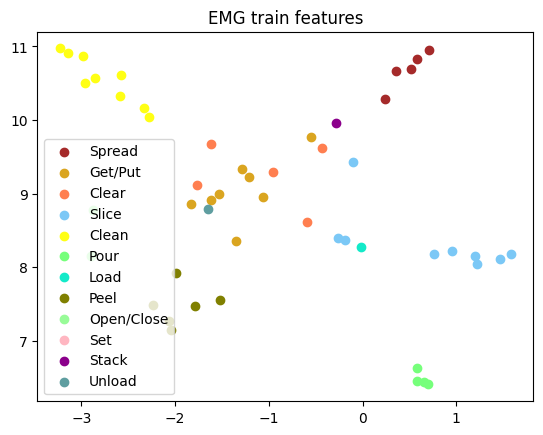

In [10]:
# plot emg features
print(len(data.iloc[0]['features_EMG']))
features = np.array([data.iloc[i].features_EMG[num_clips//2] for i in range(len(data))])
reduced = TSNE().fit_transform(features)
data['x'] = reduced[:, 0]
data['y'] = reduced[:, 1]
for i in range(12): # ek has 8 classes
    filtered = data[data["label"] == i]
    # compute the central frame
    plt.scatter(filtered['x'], filtered['y'], c=colors['AN'][i], label=labels['AN'][i])
plt.legend()
plt.title('EMG train features')
plt.show()

# Train VAE

In [ ]:
%%bash
#VAE EMG train and save

cd aml22-ego && git pull origin vae

PYTHON_PATH=/usr/local/envs/egovision/bin/python

$PYTHON_PATH train_VAE_features_EMG.py action="train_and_save" \
  name="VAE_EMG_2 full-aug lr1e-3 wkld1 sum" \
  config=configs/VAE_save_feat_EMG.yaml \
  dataset.shift=ActionNet-ActionNet \
  wandb_name='vae' \
  wandb_dir='Experiment_logs'  \
  dataset.RGB.data_path=../ek_data/frames \
  dataset.EMG.features_name='ACTIONNET_EMG/EMG_no-clip' \
  models.EMG.model='VAE' \
  models.EMG.lr=1e-3

# Train Classifier

In [41]:
%%bash
ls
cd aml22-ego/
git pull origin vae-emg-sae

aml22-ego
condacolab_install.log
drive
Already up to date.


From https://github.com/gabbiurlaro/aml22-ego
 * branch            vae-emg-sae -> FETCH_HEAD


In [51]:
%%bash
#classifier EMG train, validate and save

cd aml22-ego/
git pull origin vae-emg-sae

PYTHON_PATH=/usr/local/envs/egovision/bin/python

$PYTHON_PATH train_classifier_multimodal.py action="train" name="train_multimodal" \
  config='configs/classifier_multimodal.yaml' 

Updating 5ce5a7f..4fc7e89
Fast-forward
 train_classifier_multimodal.py | 1 +
 1 file changed, 1 insertion(+)
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8
val: 8


From https://github.com/gabbiurlaro/aml22-ego
 * branch            vae-emg-sae -> FETCH_HEAD
   5ce5a7f..4fc7e89  vae-emg-sae -> origin/vae-emg-sae
2023-06-11 18:05:28 LOG INFO Running with parameters: 
  action: train
  name: train_multimodal
  modality: ['EMG', 'RGB']
  total_batch: 128
  batch_size: 32
  gpus: None
  wandb_name: Multimodal_classification
  resume_from: None
  logname: None
  models_dir: saved_models/train_multimodal/Jun11_18-05-24
  train:
    num_iter: 300
    lr_steps: 50
    eval_freq: 50
    num_clips: 5
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
    embedding_size: 1024
  save:
    num_clips: 5
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  test:
    num_clips: 5
    dense_sampling:
      RGB: True
      EMG: False
    num_frames_per_clip:
      RGB: 16
      EMG: 32
  dataset:
    annotations_path: ../drive/MyDrive/train_val_EMG
    shift

In [ ]:
%%bash
#classifier EMG train, validate and save

PYTHON_PATH=/usr/local/envs/egovision/bin/python

$PYTHON_PATH train_classifier_EMG.py action="job_feature_extraction" name="job_feature_extraction" \
  config='configs/classifier_emg.yaml' \
  dataset.shift='ActionNet-ActionNet' \
  train.num_iter=600\
  wandb_name='vae'\
  wandb_dir='Experiment_logs'\
  dataset.RGB.data_path='../ek_data/frames'  \
  models.EMG.model='EMG_classifier' \
  resume_from='./saved_models/EMG_classifier' \
  dataset.EMG.features_name='ACTIONNET_EMG/EMG_Normalized_no-clip' 

bash: line 5: /usr/local/envs/egovision/bin/python: No such file or directory


CalledProcessError: Command 'b'#classifier EMG train, validate and save\n\nPYTHON_PATH=/usr/local/envs/egovision/bin/python\n\n$PYTHON_PATH train_classifier_EMG.py action="job_feature_extraction" name="job_feature_extraction" \\\n  config=\'configs/classifier_emg.yaml\' \\\n  dataset.shift=\'ActionNet-ActionNet\' \\\n  train.num_iter=600\\\n  wandb_name=\'vae\'\\\n  wandb_dir=\'Experiment_logs\'\\\n  dataset.RGB.data_path=\'../ek_data/frames\'  \\\n  models.EMG.model=\'EMG_classifier\' \\\n  resume_from=\'./saved_models/EMG_classifier\' \\\n  dataset.EMG.features_name=\'ACTIONNET_EMG/EMG_Normalized_no-clip\' \n'' returned non-zero exit status 127.